In [1]:
"""
Quadratic Function
^^^^^^^^^^^^^^^^^^

An example of applying SMAC to optimize a quadratic function.

We use the black-box facade because it is designed for black-box function optimization.
The black-box facade uses a :term:`Gaussian Process<GP>` as its surrogate model.
The facade works best on a numerical hyperparameter configuration space and should not
be applied to problems with large evaluation budgets (up to 1000 evaluations).
"""

import numpy as np
from ConfigSpace import Configuration, ConfigurationSpace, Float
from matplotlib import pyplot as plt
from rich import print as printr

from smac import HyperparameterOptimizationFacade as HPOFacade
from smac import RunHistory, Scenario

from dacbo.instances import create_instance_set
from omegaconf import DictConfig, OmegaConf

__copyright__ = "Copyright 2021, AutoML.org Freiburg-Hannover"
__license__ = "3-clause BSD"


class QuadraticFunction:
    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace(seed=0)
        x = Float("x", (-5, 5), default=-5)
        cs.add_hyperparameters([x])

        return cs

    def train(self, config: Configuration, seed: int = 0) -> float:
        """Returns the y value of a quadratic function with a minimum we know to be at x=0."""
        x = config["x"]
        return x**2


def plot(runhistory: RunHistory, incumbent: Configuration) -> None:
    plt.figure()

    # Plot ground truth
    x = list(np.linspace(-5, 5, 100))
    y = [xi * xi for xi in x]
    plt.plot(x, y)

    # Plot all trials
    for k, v in runhistory.items():
        config = runhistory.get_config(k.config_id)
        x = config["x"]
        y = v.cost  # type: ignore
        plt.scatter(x, y, c="blue", alpha=0.1, zorder=9999, marker="o")

    # Plot incumbent
    plt.scatter(incumbent["x"], incumbent["x"] * incumbent["x"], c="red", zorder=10000, marker="x")

    plt.show()

cfg_fn = "/home/benjamin/Dokumente/code/tmp/DAC-BO/examples/configs/base.yaml"
cfg = OmegaConf.load(cfg_fn)
instance_set = create_instance_set(cfg)
printr(instance_set)

instance = instance_set[0]
printr(instance)

# model = QuadraticFunction()

# Scenario object specifying the optimization "environment"
scenario = Scenario(instance.configuration_space, deterministic=True, n_trials=50)




[{'fid': 3, 'dimension': 2, 'instance': 1}, {'fid': 5, 'dimension': 2, 'instance': 1}, {'fid': 4, 'dimension': 2, 
'instance': 1}]

{
    0: <dacbo.instances.TargetInstance object at 0x7f93da7b4130>,
    1: <dacbo.instances.TargetInstance object at 0x7f93da7b4be0>,
    2: <dacbo.instances.TargetInstance object at 0x7f93da7b4e20>
}

Target function: '<function create_instance_set.<locals>.target_function at 0x7f93aca31000>', configuration space: 
Configuration space object:
  Hyperparameters:
    x0, Type: UniformFloat, Range: [-5.0, 5.0], Default: 0.0
    x1, Type: UniformFloat, Range: [-5.0, 5.0], Default: 0.0

In [12]:
import importlib
import baselines.portfolio_allocation
importlib.reload(baselines.portfolio_allocation)
from scipy.special import softmax

def plot_run(pofal: baselines.portfolio_allocation.PortfolioAllocation):
    import pandas as pd
    df = pd.DataFrame(pofal.history)
    acq_funs = df["acquisition_functions"][0]

    def get_array(df: pd.DataFrame, key: str):
        array = df[key].apply(np.array).to_numpy()
        array = np.array([np.array(a) for a in array])
        return array

    gains = np.array(get_array(df, "gains"), dtype=float)
    probs = softmax(gains)
    df["probs"] = [list(p) for p in probs]


    keys = ["gains", "rewards", "probs"]

    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(6,8))
    axes = fig.subplots(nrows=4, sharex=True)
    for ax, key in zip(axes, keys):
        for i, acq_fun in enumerate(acq_funs):
            arr = get_array(df, key)
            if len(arr.shape) == 1:
                arr = arr[:, None]
            ax.plot(arr[:, i], label=acq_fun)
            ax.legend()
            ax.set_xlabel("BO step")
            ax.set_ylabel(key)

    inc_costs = np.array([c[0] for c in df["incumbent_costs"]])
    axes[3].plot(inc_costs, scaley="log")
    axes[3].set_xlabel("BO step")
    axes[3].set_ylabel("incumbent cost")

    fig.set_tight_layout(True)
    plt.show()

# Rollout

[
    <smac.acquisition.function.confidence_bound.LCB object at 0x7f939efff280>,
    <smac.acquisition.function.probability_improvement.PI object at 0x7f939effd2a0>,
    <smac.acquisition.function.expected_improvement.EI object at 0x7f939effd330>
]

[INFO][abstract_initial_design.py:81] Reducing the number of initial configurations from 20 to 12 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:133] Using 12 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:496] Added config 74ca25 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:568] Added config 30143b and rejected config 74ca25 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:176] --- x0: -2.331214789301157 -> 1.0521896090358496
[INFO][configspace.py:176] --- x1: 1.2056469544768333 -> 2.4109967052936554
[INFO][abstract_intensifier.py:568] Added config 33cab8 and rejected config 30143b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:176] --- x0: 1.0521896090358496 -> 1.6678992005960955
[INFO][configspace.py:176] --- x1:

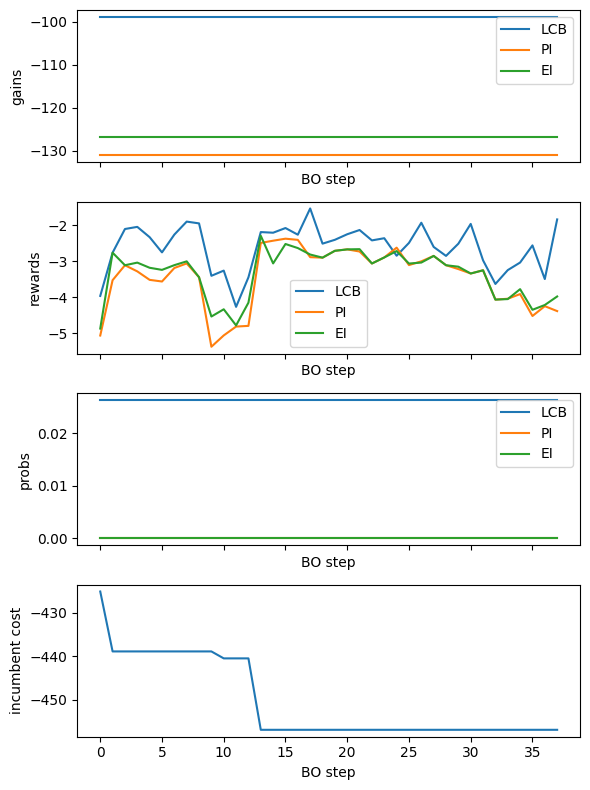

In [17]:
import importlib
import awei.baselines.portfolio_allocation
importlib.reload(baselines.portfolio_allocation)

from smac.acquisition.function.confidence_bound import LCB
from smac.acquisition.function.expected_improvement import EI
from smac.acquisition.function.probability_improvement import PI

acquisition_functions = [
    # [EI()],
    # [LCB()],
    # [PI()],
    # [PI(), EI()],
    [LCB(), PI(), EI()]
]

pofals = []
seeds = [0,1,2,3,4]
seeds = [0]

for seed in seeds:
    for acq_funs in acquisition_functions:
        printr(acq_funs)
        gphedge = awei.baselines.portfolio_allocation.GPHedge(configspace=scenario.configspace, seed=scenario.seed)
        macq = awei.baselines.portfolio_allocation.MultiAcquisitionFunction(acq_funs)
        pofal = awei.baselines.portfolio_allocation.PortfolioAllocation()
        callbacks = [pofal]

        config_selector = HPOFacade.get_config_selector(scenario=scenario, retrain_after=1)

        # Now we use SMAC to find the best hyperparameters
        smac = HPOFacade(
            scenario,
            instance.__call__,  # We pass the target function here
            overwrite=True,  # Overrides any previous results that are found that are inconsistent with the meta-data
            callbacks=callbacks,
            acquisition_maximizer=gphedge,
            acquisition_function=macq,
            config_selector=config_selector
        )

        incumbent = smac.optimize()

        # Get cost of default configuration
        default_cost = smac.validate(instance.configuration_space.get_default_configuration())
        print(f"Default cost: {default_cost}")

        # Let's calculate the cost of the incumbent
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost: {incumbent_cost}")

        plot_run(pofal)

        pofals.append(pofal)

# Let's plot it too
# plot(smac.runhistory, incumbent)

# Analyze

(950,) (190,)


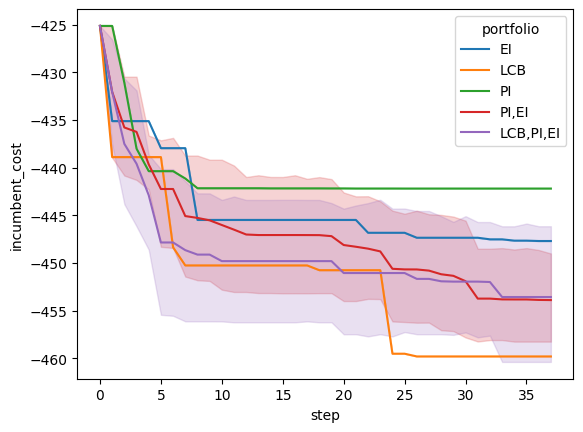

In [9]:
import pandas as pd
inc_costs = [np.array([c[0] for c in pd.DataFrame(p.history)["incumbent_costs"]]) for p in pofals]
steps = np.concatenate([np.arange(len(C)) for C in inc_costs])
portfolios = [[",".join([type(a).__name__ for a in AFs])] for AFs in acquisition_functions]
AFs = [[a]*len(C) for C, a in zip(inc_costs, portfolios)]
print(np.concatenate(inc_costs).shape, np.squeeze(np.concatenate(AFs)).shape)
df = pd.DataFrame({"incumbent_cost": np.concatenate(inc_costs), "portfolio": np.concatenate([np.squeeze(np.concatenate(AFs))]*len(seeds))})
df["step"] = steps

import seaborn as sns
sns.lineplot(data=df, x="step", y="incumbent_cost", hue="portfolio")
plt.show()